# Plot the timeseries data from Proteomics

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None

## Read Data

### LFQ Data

In [12]:
# Read log2-transformed LFQ intensity from shaving data
shaving = pd.read_excel('input_files/20220216_identified_quantified_proteins_shaving.xlsx', #noqa: E501
                            sheet_name = 'quantified_proteins',
                            header = 1)

sn = pd.read_excel('input_files/20220428_identified_quantified_supernatant.xlsx',
                        sheet_name = 'quantified_proteins',
                        header = 1)

# Fix stupid names with spaces
shaving.columns = shaving.columns.str.replace(' ', '')
shaving = shaving[:-1]

sn.columns = sn.columns.str.replace(' ', '')
sn = sn[:-1]

### Read Metadata

In [13]:
# Load full protein info
full_sequences = pd.read_csv("input_files/sequences_annotated.csv",
                            index_col = 0)

## Prepare Data

### Merge Metadata

In [14]:
shaving_annotated = shaving.merge(full_sequences[['SeqID',
                                                  'shortname',
                                                  'description',
                                                  'amylosome_component']],
                           left_on = 'ProteinIDs',
                           right_on = 'SeqID',
                           how = 'left',
                           validate = '1:m')

sn_annotated = sn.merge(full_sequences[['SeqID',
                                           'shortname',
                                                 'description',
                                                 'amylosome_component']],
                           left_on = 'ProteinIDs',
                           right_on = 'SeqID',
                           how = 'left',
                           validate = '1:m')

shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.astype('boolean') #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.astype('boolean')

### Define Conditions

In [15]:
# Define Names of timepoints
time_names = ['mid-log','end-log','stationary']

# Define Conditions with Shorthand and Timepoints
conditions = {'Fructose': ['F',[10, 14, 20]],
              'Pullulan': ['P',[8,12,20]],
              'Starch': ['S',[8,12,20]],
              'RS': ['resistantS',[5,10,20]]}

# Make list for easier handling
include_columns = []

for _, [shorthand, times] in conditions.items():
     # Iterate over Timepoints
    for t in range(3):
        # Iterate over Replicates
        for i in range(1,4):
            include_columns.append(f'{shorthand}{times[t]}_{i}')



In [16]:
sn_annotated = sn_annotated[sn_annotated[include_columns].notna().any(axis=1)]
shaving_annotated = shaving_annotated[shaving_annotated[include_columns].notna().any(axis=1)] #noqa: E501

### LFQ and Z-score over Time

#### Timeseries Amylosome Proteins

In [17]:
poi_dict = {}

for _, row in full_sequences[full_sequences.amylosome_component].iterrows():
    poi_dict[row.shortname] = row.SeqID

In [18]:
# Dataframe
timeseries = pd.DataFrame(columns = ['ProteinID',
                                     'Name',
                                     'Carb',
                                     'Time_h',
                                     'Timepoint',
                                     'Abundance_Shaving',
                                     'Rel_Abundance_Shaving',
                                     'Abundance_SN',
                                     'replicate'])

# Iterate over Proteins
for protein, proteinid in poi_dict.items():

    # Iterate over Carbon Sources
    for carb, [shorthand, times] in conditions.items():

        # Iterate over Timepoints
        for t in range(3):

            # Iterate over Replicates
            for i in range(1,4):

                col_name = f'{shorthand}{times[t]}_{i}'
                col_name_raw = f'{col_name}_raw'

                temp = {'ProteinID': proteinid,
                         'Name': protein,
                         'Carb': carb,
                         'Time_h': times[t],
                         'Timepoint': time_names[t],
                         'replicate': i}

                if len(shaving_annotated.loc[shaving_annotated.ProteinIDs == proteinid,
                                             col_name]) != 0:
                    shaving_annotated[col_name_raw] = 2 ** shaving_annotated[col_name]

                    temp['Abundance_Shaving'] = shaving_annotated[shaving_annotated.SeqID == proteinid][col_name].item() #noqa: E501
                    temp['Rel_Abundance_Shaving'] = (shaving_annotated.loc[shaving_annotated.ProteinIDs == proteinid, col_name_raw].iloc[0] / #noqa: E501
                                                     shaving_annotated[shaving_annotated.amylosome_component][col_name_raw].sum()).item(),

                if len(sn_annotated.loc[sn_annotated.ProteinIDs == proteinid,
                                        col_name]) != 0:
                    temp['Abundance_SN'] = sn_annotated[sn_annotated.ProteinIDs == proteinid][col_name].item() #noqa: E501

                timeseries.loc[len(timeseries)] = temp

# To not turn insane, turn the relative abundance column from tuple to float
for index, value in timeseries.Rel_Abundance_Shaving.items():
    if value == "nan":
        continue
    if isinstance(value, tuple):
        timeseries.loc[index, "Rel_Abundance_Shaving"] = value[0]


## Plot

In [19]:
# Carb Palette defined based on ColorBrewer 5-class BrBG
carb_palette = {"Pullulan": "#a6611a",
                "Fructose": "#969696",
                "Starch": "#80cdc1",
                "RS": "#018571",
                }

### Plot Amylosome Proteins

In [20]:
# Just sort the proteins manually before I figure out any automated way (33 total)
sorted_names = ['Amy3', 'Amy4 (Sca1)', 'Amy9','Amy10', 'Amy12', 'Amy16',
                'Sca2', 'Sca3', 'Sca4', 'Sca5',
                'Sas6', 'Sas20',
                'Bacterial Ig-like domain', 'Beta-glucanase precursor',
                'CwlS precursor', 'Endoglucanase A precursor',
                'Leucine-rich repeat protein', 'Papain family cysteine protease ',
                'Peptidase-doc', 'Predicted outer membrane protein',
                'Starch-binding protein', 'Subtilisin BL', 'Tranglutaminase-doc',
                'Doc8', 'Doc1814', 'Doc1842', 'Doc1960', 'Doc2515',
                'Doc2537', 'Doc2584', 'Doc2688', 'Doc2993', 'Doc3160',
                ]

# Also, a cleaned version: only those  detected in at least two timepoints
# 23 proteins remaining
sorted_names_cleaned = ['Amy4 (Sca1)', 'Amy9','Amy10', 'Amy12', 'Amy16',
                'Sca2', 'Sca3', 'Sca4', 'Sca5',
                'Sas6', 'Sas20',
                'Bacterial Ig-like domain', 'Beta-glucanase precursor',
                'Papain family cysteine protease ',
                'Starch-binding protein', 'Subtilisin BL',
                'Doc8', 'Doc1842', 'Doc1960',
                'Doc2537', 'Doc2688', 'Doc2993', 'Doc3160',
                ]

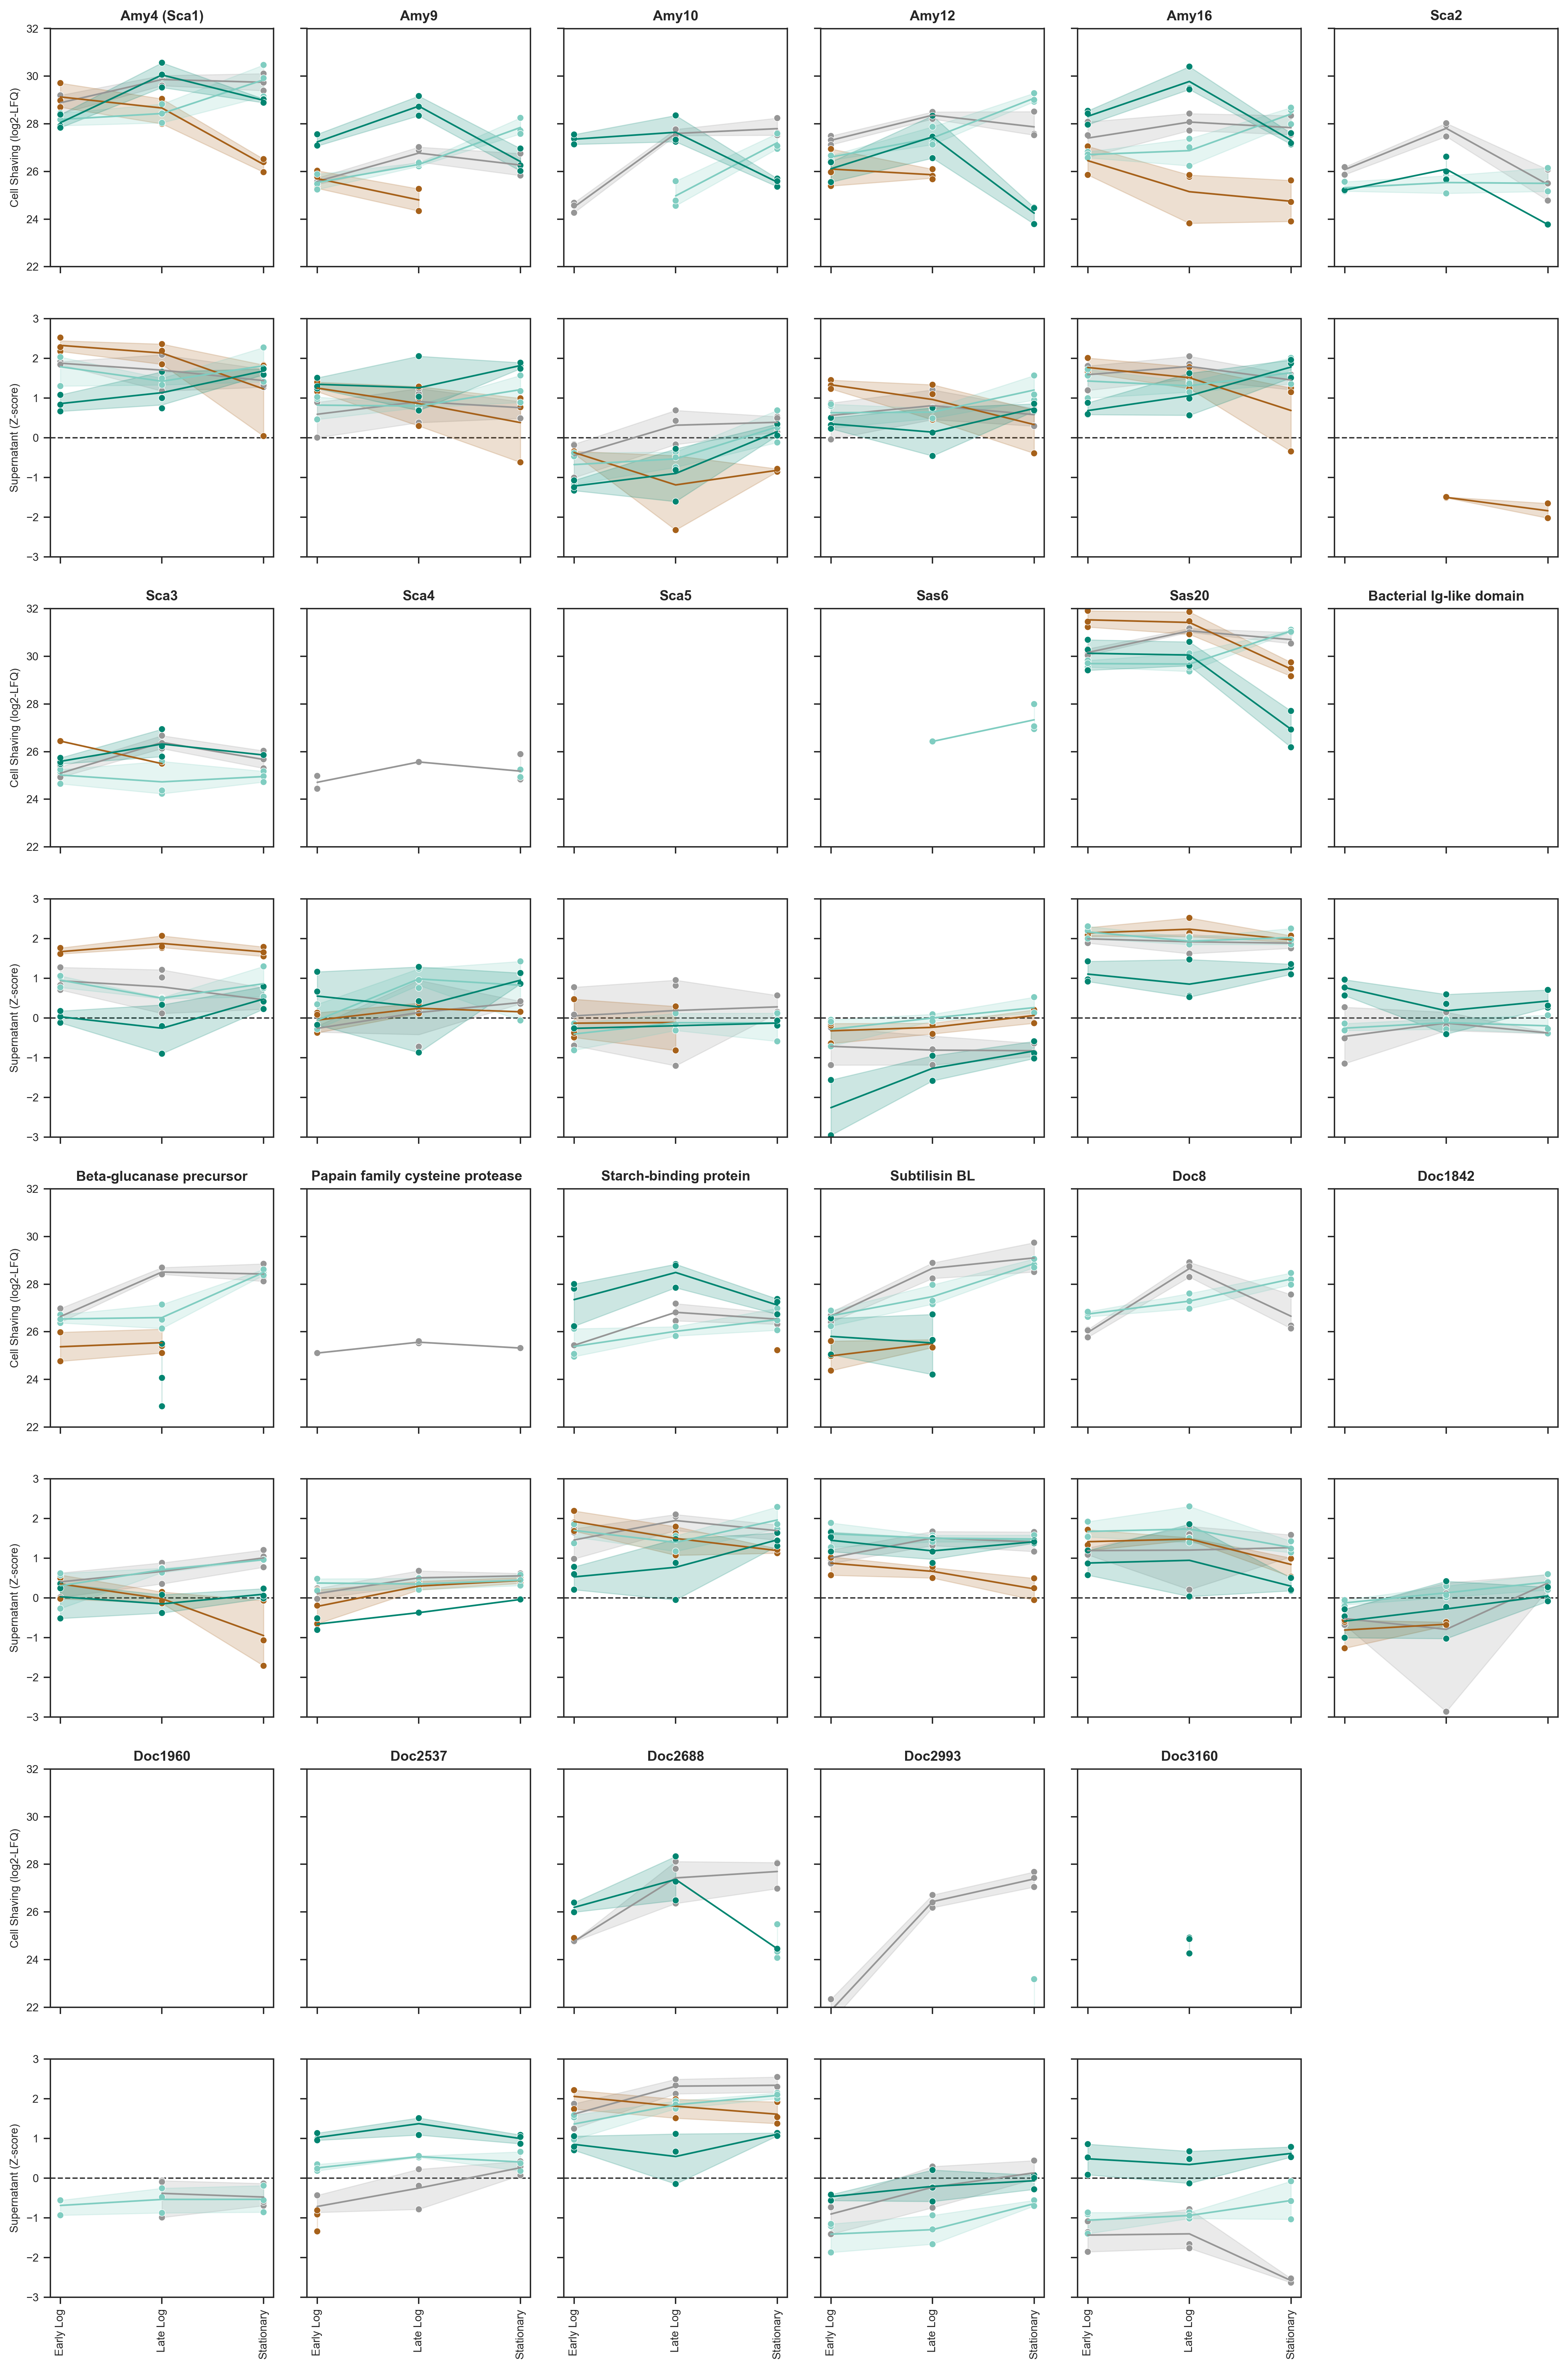

In [22]:
# Plot into panels
figure, axis = plt.subplots(nrows=8,
                            ncols=6,
                            sharex=True,
                            sharey='row',
                            dpi=300,
                            figsize=(16, 24))


sns.set_theme('paper',
              style = 'ticks')

i = 0

for protein in sorted_names_cleaned:

    row = 2*int(i/6)
    col = i % 6

    # LFQ Abundance Shaving
    sns.lineplot(data = timeseries[timeseries.Name == protein],
                x = "Timepoint",
                y = "Abundance_Shaving",
                hue="Carb",
                palette = carb_palette,
                err_style = "band",
                ax = axis[row + 0, col],
                legend = False,
                )

    sns.scatterplot(data = timeseries[timeseries.Name == protein],
                    x = "Timepoint",
                    y = "Abundance_Shaving",
                    hue="Carb",
                    palette=carb_palette,
                    ax = axis[row + 0, col],
                    legend = False)

    # Abundance SN
    sns.lineplot(data = timeseries[timeseries.Name == protein],
                x = "Timepoint",
                y = "Abundance_SN",
                hue="Carb",
                palette = carb_palette,
                err_style = "band",
                ax = axis[row + 1, col],
                legend = False)

    sns.scatterplot(data = timeseries[timeseries.Name == protein],
                    x = "Timepoint",
                    y = "Abundance_SN",
                    hue="Carb",
                    palette=carb_palette,
                    ax = axis[row + 1, col],
                    legend = False)

    axis[row + 1, col].axhline(0,
                            color="black",
                            lw = 1,
                            linestyle="--",
                            alpha = 0.8,
                            zorder = -2)

    axis[row + 0, col].set_title(protein,
                           weight = "bold",
                                fontsize = 10)

    axis[row + 1, col].set_xlabel('')
    axis[row + 1, col].set_xticks(range(3))
    axis[row + 1, col].set_xticklabels(['Early Log',
                                        'Late Log',
                                        'Stationary'],
                                       rotation = 90,
                                      fontsize = 8)

    if col == 0:
        axis[row+0, col].set_ylabel("Cell Shaving (log2-LFQ)",
                                   fontsize = 8)
        axis[row+0, col].set_ylim([22,32])
        axis[row+0, col].tick_params(axis='both',
                                     which='major',
                                     labelsize=8)

        axis[row+1, col].set_ylabel("Supernatant (Z-score)",
                                   fontsize = 8)
        axis[row+1, col].set_ylim([-3,3])
        axis[row+1, col].tick_params(axis='both',
                                     which='major',
                                     labelsize=8)

    else:
        axis[row+0, col].set_ylabel("")
        axis[row+1, col].set_ylabel("")

    i = i + 1

# Remove leftover plots
axis[6,5].set_axis_off()
axis[7,5].set_axis_off()

figure.tight_layout(pad=2)